In [130]:
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.display import HTML, Latex, Markdown, Pretty

from windIO.Plant import WTLayout
from fusedwake.WindFarm import WindFarm
from fusedwake.Inflow import get_ABL_U, RotorAvg
from fusedwake.Plotting import circles
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

from fusedwake.gcl import GCL
import fusedwake.gcl.fortran as fgcl

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
filename = 'test_4rotor_prototype.yml'

#wtl = WTLayout(filename)
wf = WindFarm(yml=filename)

In [132]:
gcl = GCL(WF=wf)

### Computing rotor equivalent wind speed based on a given ABL scheme.

Note that the default values for the 'pow' law do not give the same profile as the default values for the 'log' or 'MOB' profiles. These profiles coincide when the reference height is apporx 10 m.

In [133]:
z_plot = np.linspace(0.01,200.,100)
U_plot1 = get_ABL_U(z_plot, Ur=10., zr=80., type='log', z0=0.0002)
U_plot2 = get_ABL_U(z_plot, Ur=10., zr=80., type='pow', alpha=0.078)
U_plot20 = get_ABL_U(z_plot, Ur=10., zr=80., type='pow')
U_plot3 = get_ABL_U(z_plot, Ur=10., zr=80., type='MOB')

Using default ABL power law shear coefficient: alpha = 0.143 (Offshore)
Using default MOB characteristic roughness length of the terrain: z0 = 0.0002 (Offshore)
Using default MOB Monin-Obukhov length: L = -1000 (Neutral from unstable asymptote)
Using default MOB ABL height: zi = 400 [m]


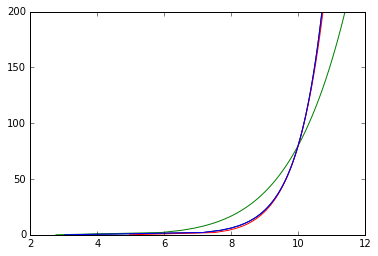

In [134]:
plt.plot(U_plot1,z_plot,'-k')
plt.plot(U_plot20,z_plot,'-g')
plt.plot(U_plot2,z_plot,'-r')
plt.plot(U_plot3,z_plot,'-b')

In [135]:
#RotorAvg(get_ABL_U, H=wf.H, R=wf.R, dep='z', Ur=10., zr=80., type='pow', alpha=0.143)
#RotorAvg(get_ABL_U, H=wf.H, R=wf.R, dep='z', Ur=10., zr=80., type='log', z0=0.005)
WS=RotorAvg(get_ABL_U, H=wf.H, R=wf.R, dep='z', Ur=10., zr=80., type='MOB', L=-400.,z0=0.005,zi=400.)

In [146]:
# Inputs
print WS
WD=180*np.ones([wf.nWT])
TI=0.1*np.ones([wf.nWT])

# Run the models
out=gcl(WS=WS, WD=WD, TI=TI, version='fort_gclm')
out.p_wt.sum()

[  9.81588238   9.81588238  10.66769842  10.66769842   9.81588238
   9.81588238  10.66769842  10.66769842]


8801075.4646503218

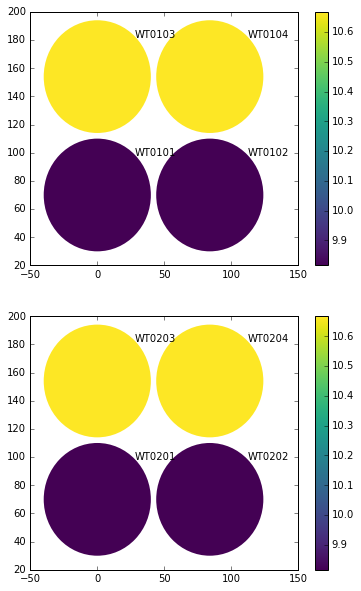

In [147]:
fig = plt.figure(figsize=[6,10])
ax = fig.add_subplot(211)
upstream=range(4)
circles(x=wf.xyz[0,upstream],
        y=wf.xyz[2,upstream],
        s=np.array(wf.R)[upstream],
        c=WS[upstream], 
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in upstream:
    ax.annotate(str(wf.__getattr__('name')[i]).zfill(2),wf.xyz[[0,2],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    '''
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=3*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
    #'''

ax = fig.add_subplot(212)
upstream=range(4,8)
circles(x=wf.xyz[0,upstream],
        y=wf.xyz[2,upstream],
        s=np.array(wf.R)[upstream],
        c=WS[upstream], 
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in upstream:
    ax.annotate(str(wf.__getattr__('name')[i]).zfill(2),wf.xyz[[0,2],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    '''
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=3*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
    #'''



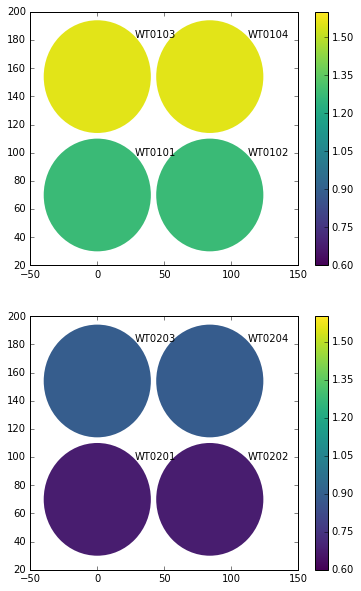

In [148]:

fig = plt.figure(figsize=[6,10])
ax = fig.add_subplot(211)
upstream=range(4)
circles(x=wf.xyz[0,upstream],
        y=wf.xyz[2,upstream],
        s=np.array(wf.R)[upstream],
        c=out.p_wt[upstream]/1e6, 
        cmap=plt.cm.viridis,lw=0,
        vmin = 0.6,vmax = 1.6,
        )
plt.colorbar()
for i in upstream:
    ax.annotate(str(wf.__getattr__('name')[i]).zfill(2),wf.xyz[[0,2],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    '''
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=3*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
    #'''

ax = fig.add_subplot(212)
upstream=range(4,8)
circles(x=wf.xyz[0,upstream],
        y=wf.xyz[2,upstream],
        s=np.array(wf.R)[upstream],
        c=out.p_wt[upstream]/1e6, 
        cmap=plt.cm.viridis,lw=0,
        vmin = 0.6,vmax = 1.6,
        )
plt.colorbar()
for i in upstream:
    ax.annotate(str(wf.__getattr__('name')[i]).zfill(2),wf.xyz[[0,2],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    '''
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=3*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
    #'''




(-200, 200)

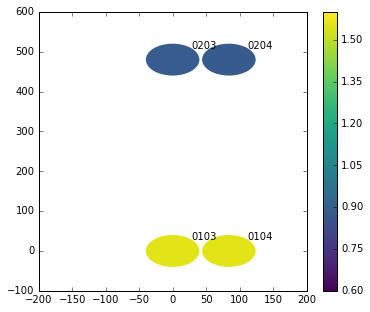

In [161]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
higher=[2,3,6,7]
circles(x=wf.xyz[0,higher],
        y=wf.xyz[1,higher],
        s=np.array(wf.R)[higher],
        c=out.p_wt[higher]/1e6, 
        cmap=plt.cm.viridis,lw=0,
        vmin = 0.6,vmax = 1.6,
        )
plt.colorbar()
for i in higher:
    ax.annotate(str(wf.__getattr__('name')[i][-4:]).zfill(2),wf.xyz[[0,1],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    '''
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=3*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
    #'''

ax.set_xlim([-200, 200])
#ax.set_ylim([-500, 500])

In [162]:
WD = np.arange(-20,20)+270

In [163]:
P_rat_py_v0 = []
P_rat_py_v1 = []
for wd in WD:
    out = gcl(WS=WS, WD=wd*np.ones([wf.nWT]), TI=0.1*np.ones([wf.nWT]), version='py_gcl_v0')
    P_rat_py_v0 = np.append(P_rat_py_v0,out.p_wt[5]/out.p_wt[2])
    
    out = gcl(WS=WS, WD=wd*np.ones([wf.nWT]), TI=0.1*np.ones([wf.nWT]), version='py_gcl_v1')
    P_rat_py_v1 = np.append(P_rat_py_v1,out.p_wt[5]/out.p_wt[2])  

In [164]:
#out = gcl(WF=wf, WS=WS*np.ones_like(WD), WD=WD, TI=0.1*np.ones_like(WD), version='fort_gcl')
#P_rat_fgcl = out.p_wt[:,5]/out.p_wt[:,2]

WDm = WD.reshape([-1,1])*np.ones([1,wf.nWT])
out = gcl(WF=wf, WS=WS*np.ones_like(WDm), WD=WDm, TI=0.1*np.ones_like(WDm), version='fort_gclm')
P_rat_fgclm = out.p_wt[:,5]/out.p_wt[:,2]

out = gcl(WF=wf, WS=WS*np.ones_like(WDm), WD=WDm+np.random.normal(loc=0.0, scale=2, size=WDm.shape), 
          TI=0.1**np.ones_like(WDm), version='fort_gclm')
P_rat_fgclm_rdn = out.p_wt[:,5]/out.p_wt[:,2]

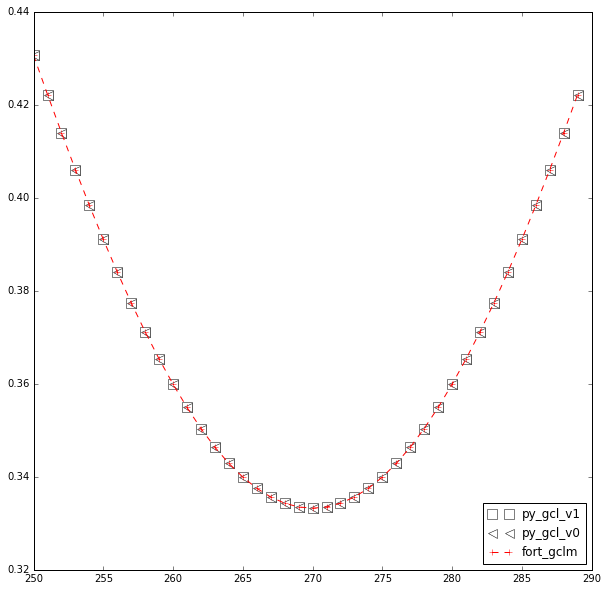

In [165]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)

plt.plot(WD,P_rat_py_v1,'sk',ms=10,mfc='w',label ='py_gcl_v1')
#plt.plot(-WD,P_rat_py_v1,'x--',label ='py_gcl_v1_inv')

plt.plot(WD,P_rat_py_v0,'<b',ms=9,mfc='w',label ='py_gcl_v0')
#plt.plot(-WD,P_rat_py_v0,'-',label ='py_gcl_v0_inv')

#plt.plot(WD,P_rat_fgcl,'-ok',ms=8,mec='k',mfc='w',label ='fort_gcl')
#plt.plot(-WD,P_rat_fgcl,'+--',label ='fort_gcl')

plt.plot(WD,P_rat_fgclm,'--+r',label ='fort_gclm')
#plt.plot(-WD,P_rat_fgclm_s,'.-',label ='fort_gclm')

#plt.plot(WD,P_rat_fgclm_rdn,'o',label ='fort_gclm_s_rdn')

plt.legend(loc=4)